In [350]:
%matplotlib inline

In [351]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

## Load Your Dataset
Replace the path below with the actual location of your CSV or Parquet file.

In [352]:
final_demo = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_demo.txt')
# A list revealing which clients were part of the grand experiment
df_final_experiment_clients = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_experiment_clients.txt')
# A detailed trace of client interactions online, divided into two parts: 
# pt_1 and pt_2. It's recommended to merge these two files prior to a comprehensive data analysis.
df_final_web_data_pt_1 = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_web_data_pt_1.txt')
df_final_web_data_pt_2 = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_web_data_pt_2.txt')
# pt1 and pt2 are combined
combined = pd.concat([df_final_web_data_pt_1, df_final_web_data_pt_2], ignore_index=True)
combined = combined.merge(
    df_final_experiment_clients[['client_id','Variation']], 
    on='client_id',
    how='left'
)
# Rename for consistency
combined = combined.rename(columns={'Variation':'variation'})

# Normalize casing just in case
combined['variation'] = combined['variation'].str.strip().str.lower()

In [353]:
final_demo.head()
# Who are the primary clients using this online process? - Test group
final_demo_clean = final_demo.copy()
final_demo_clean['gender'] = final_demo_clean['gendr'].replace(['U', 'X', 'NaN'], 'U')

# final_demo[['client_id', 'clnt_age', 'gendr']] 

median_age = final_demo_clean['clnt_age'].median()
median_tenure_year = final_demo_clean['clnt_tenure_yr'].median()
median_tenure_month = final_demo_clean['clnt_tenure_mnth'].median()
final_demo_clean['tenure_years'] = final_demo_clean['clnt_tenure_yr'].apply(lambda x: 'new-standing' if x<median_tenure_year else 'long-standing')
final_demo_clean['tenure_month'] = final_demo_clean['clnt_tenure_mnth'].apply(lambda x: 'new-standing' if x<median_tenure_month else 'long-standing')
final_demo_clean['age_group'] = final_demo_clean['clnt_age'].apply(lambda x: 'younger' if x<median_age else 'older')

clients_age_tenure = final_demo_clean[['client_id', 'gender', 'age_group', 'tenure_years', 'tenure_month']]
test_group = df_final_experiment_clients[df_final_experiment_clients['Variation'] == 'Test']
merged_clients = pd.merge(clients_age_tenure, test_group, on='client_id', how='inner')
merged_clients.head()

,client_id,gender,age_group,tenure_years,tenure_month,Variation
0,836976,U,older,new-standing,new-standing,Test
1,1439522,U,younger,new-standing,new-standing,Test
2,1562045,M,older,long-standing,long-standing,Test
3,388801,M,older,long-standing,long-standing,Test
4,8198645,F,older,long-standing,long-standing,Test


In [354]:
display(merged_clients)

,client_id,gender,age_group,tenure_years,tenure_month,Variation
0,836976,U,older,new-standing,new-standing,Test
1,1439522,U,younger,new-standing,new-standing,Test
2,1562045,M,older,long-standing,long-standing,Test
3,388801,M,older,long-standing,long-standing,Test
4,8198645,F,older,long-standing,long-standing,Test
...,...,...,...,...,...,...
26963,501496,F,younger,long-standing,long-standing,Test
26964,1780858,M,older,long-standing,long-standing,Test
26965,5826160,F,older,long-standing,long-standing,Test
26966,8739285,F,older,long-standing,long-standing,Test


## Preprocessing and Feature Engineering

In [355]:
from pandas.api.types import CategoricalDtype

# 1) Define the logical order once
step_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
step_dtype = CategoricalDtype(categories=step_order, ordered=True)

# 2) Ensure process_step uses this categorical order
combined['process_step'] = combined['process_step'].astype(step_dtype)

# 3) (Your existing time calc stays the same)
combined['date_time'] = pd.to_datetime(combined['date_time'])
combined = combined.sort_values(by=['visitor_id', 'visit_id', 'date_time'])
combined['next_time'] = combined.groupby(['visitor_id', 'visit_id'])['date_time'].shift(-1)
combined['time_spent'] = (combined['next_time'] - combined['date_time']).dt.total_seconds()

# 4) Map to ordered numbers using the categorical codes (no reliance on .unique())
combined['step_number'] = combined['process_step'].cat.codes
combined['next_step'] = combined.groupby(['visitor_id', 'visit_id'])['step_number'].shift(-1)
combined['step_change'] = combined['next_step'] - combined['step_number']
combined['backward_flag'] = combined['step_change'] < 0

combined.head()



,client_id,visitor_id,visit_id,process_step,date_time,variation,next_time,time_spent,step_number,next_step,step_change,backward_flag
444289,5867343,100011869_84756704576,406596333_52561114200_989487,start,2017-06-05 02:47:42,NaN,2017-06-05 02:47:47,5.0,0,1.0,1.0,False
444288,5867343,100011869_84756704576,406596333_52561114200_989487,step_1,2017-06-05 02:47:47,NaN,2017-06-05 02:48:03,16.0,1,2.0,1.0,False
444287,5867343,100011869_84756704576,406596333_52561114200_989487,step_2,2017-06-05 02:48:03,NaN,2017-06-05 02:50:18,135.0,2,3.0,1.0,False
444286,5867343,100011869_84756704576,406596333_52561114200_989487,step_3,2017-06-05 02:50:18,NaN,2017-06-05 02:51:11,53.0,3,0.0,-3.0,True
444285,5867343,100011869_84756704576,406596333_52561114200_989487,start,2017-06-05 02:51:11,NaN,NaT,NaN,0,NaN,NaN,False


In [356]:
#KPIs
#1
# A session completes if it contains the 'confirm' step


## Visualization: Average Time per Step

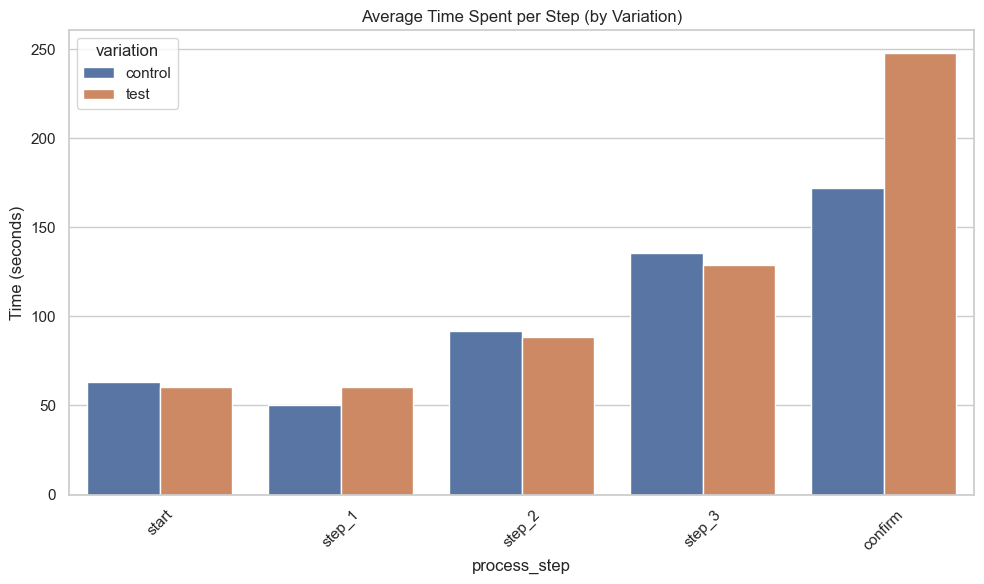

In [357]:
#How much time do users spend on each step on average? Overview

avg_time = (combined.loc[combined['time_spent'].notna()]
                     .groupby('process_step')['time_spent']
                     .mean()
                     .reset_index())
avg_time = combined.groupby(['variation','process_step'])['time_spent'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_time, x='process_step', y='time_spent', hue='variation', order=step_order)
plt.title('Average Time Spent per Step (by Variation)')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Visualization: Error Rate (Backward Navigation) per Step

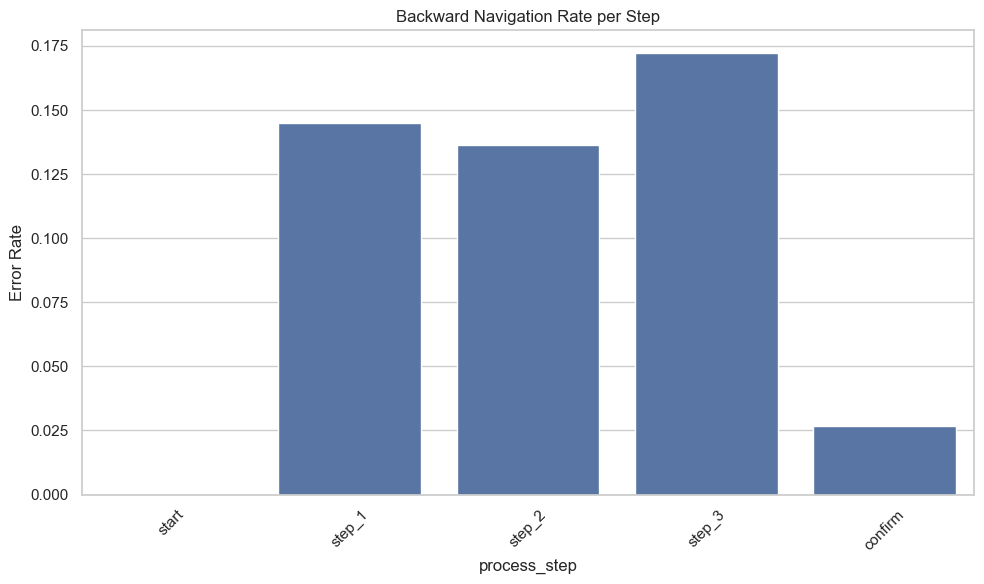

In [358]:
#How often do users go back to a previous step? Overview

error_rate = combined.groupby('process_step')['backward_flag'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=error_rate, x='process_step', y='backward_flag')
plt.title('Backward Navigation Rate per Step')
plt.ylabel('Error Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [359]:
# Compute backward navigation rates
error_rates = (
    combined.groupby(['process_step'])['backward_flag']
    .mean()  # mean of boolean = share of True
    .reset_index()
)

error_rates.rename(columns={'backward_flag': 'error_rate'}, inplace=True)
print(error_rates)

  process_step  error_rate
0        start    0.000000
1       step_1    0.144798
2       step_2    0.136222
3       step_3    0.172440
4      confirm    0.026874


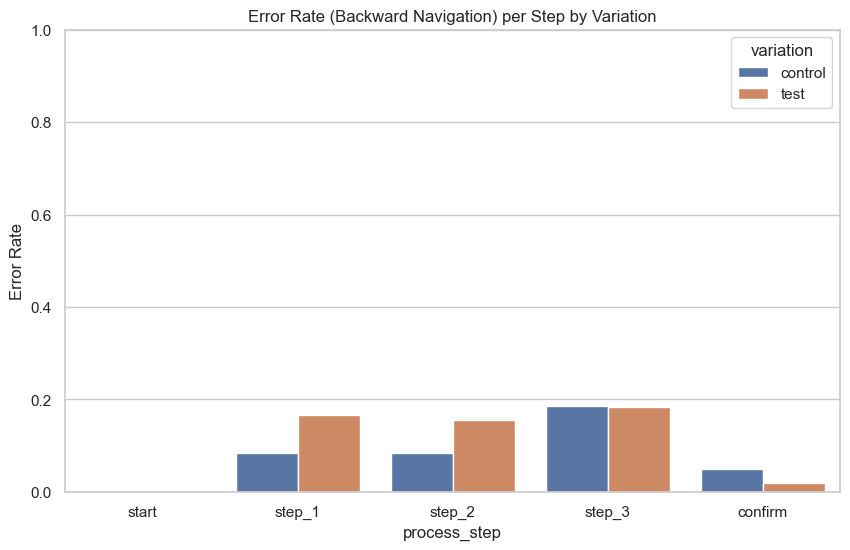

In [360]:
error_rates_var = (
    combined.groupby(['variation','process_step'])['backward_flag']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,6))
sns.barplot(data=error_rates_var, x='process_step', y='backward_flag', hue='variation', order=order)
plt.title("Error Rate (Backward Navigation) per Step by Variation")
plt.ylabel("Error Rate")
plt.ylim(0,1)
plt.show()

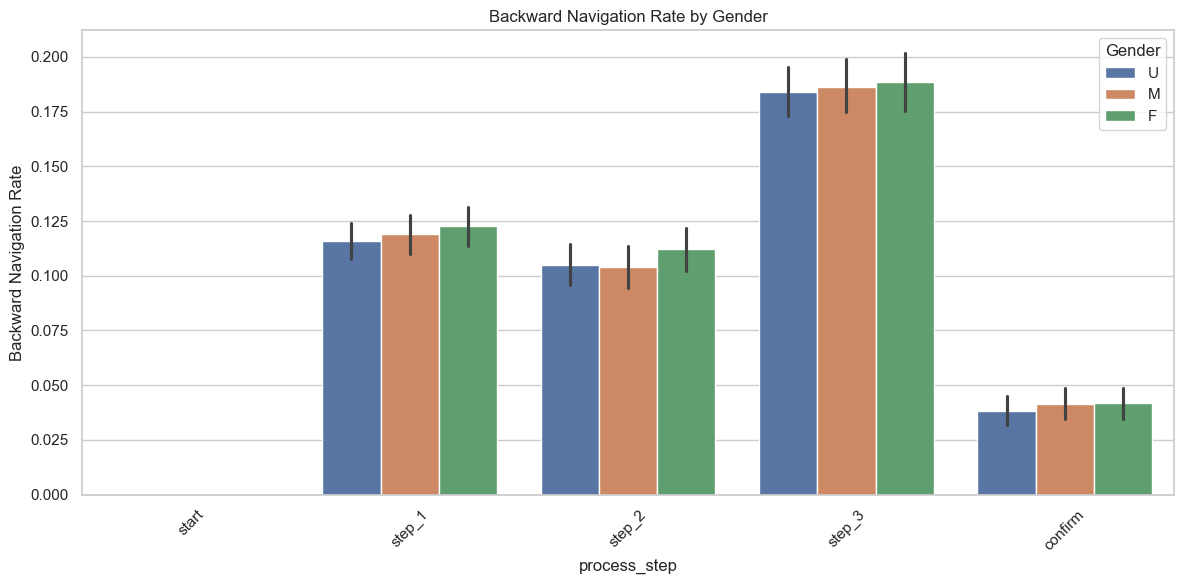

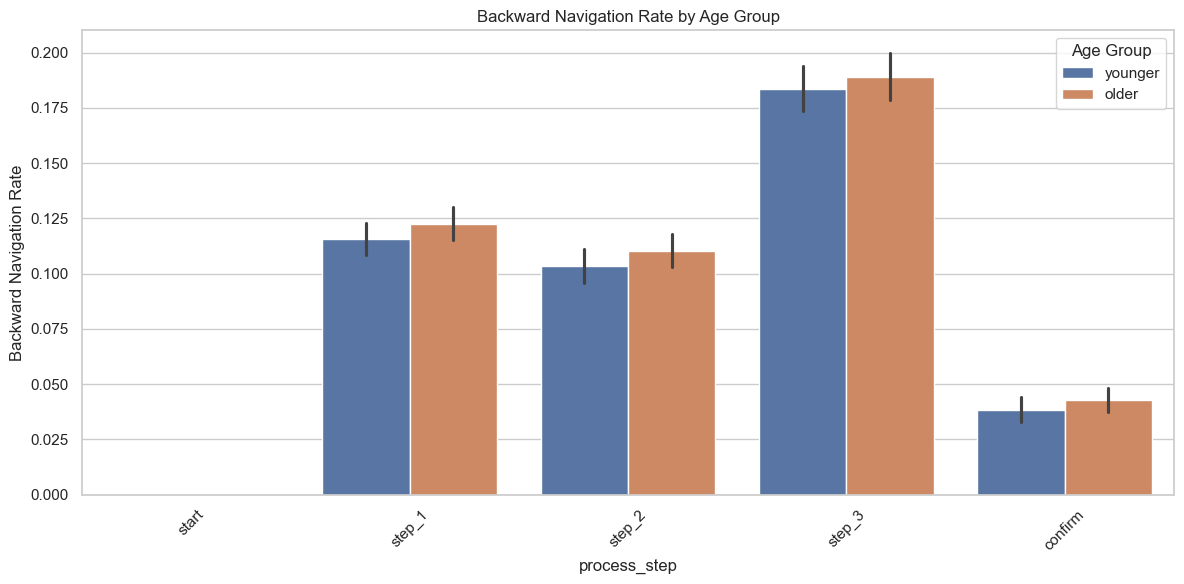

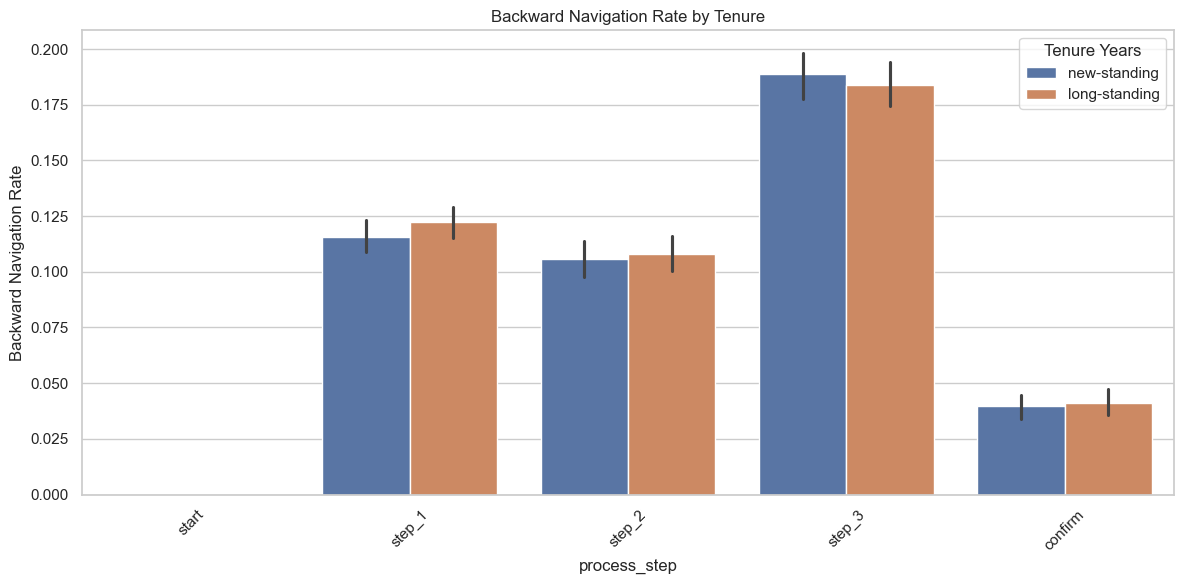

In [361]:
# Ensure combined has the relevant columns from final_demo_clean
for col in ['gender', 'age_group', 'tenure_years']:
    if col in final_demo_clean.columns:
        combined[col] = final_demo_clean[col]
    else:
        print(f"⚠️ Column '{col}' does not exist in final_demo_clean and will be skipped.")

# Clean column names
combined.columns = combined.columns.str.strip().str.lower()

# Define plots to generate
plots = [
    {'hue': 'gender', 'title': 'Backward Navigation Rate by Gender', 'ylabel': 'Backward Navigation Rate'},
    {'hue': 'age_group', 'title': 'Backward Navigation Rate by Age Group', 'ylabel': 'Backward Navigation Rate'},
    {'hue': 'tenure_years', 'title': 'Backward Navigation Rate by Tenure', 'ylabel': 'Backward Navigation Rate'}
]

# Loop through each plot
for p in plots:
    hue_col = p['hue']
    if hue_col not in combined.columns:
        print(f"⚠️ Column '{hue_col}' not found in combined. Skipping this plot.")
        continue
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=combined, x='process_step', y='backward_flag', hue=hue_col)
    plt.title(p['title'])
    plt.ylabel(p['ylabel'])
    plt.xticks(rotation=45)
    plt.legend(title=hue_col.replace('_', ' ').title())
    plt.tight_layout()
    plt.show()

## Visualization: Completion Funnel

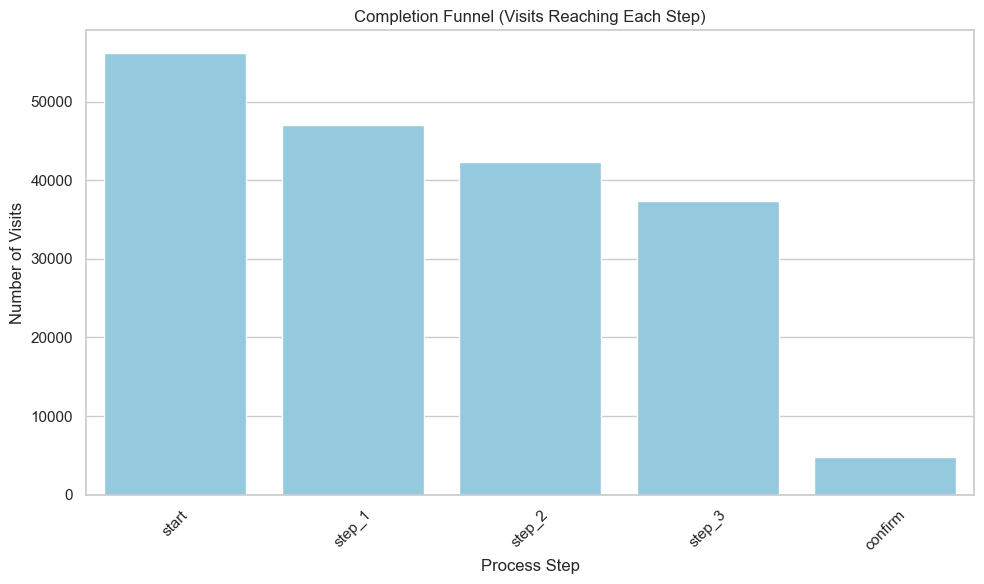

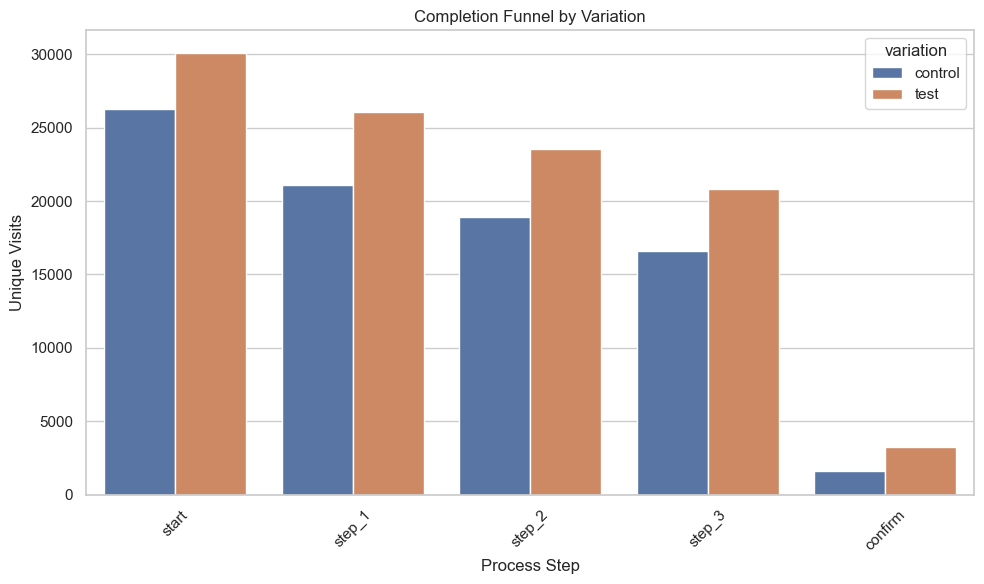

In [379]:
#What proportion of users reach the final 'confirm' step? Overview

funnel = (
    combined.groupby(['process_step'])[['visitor_id','visit_id']]
    .nunique()              # count unique users/sessions
    .reset_index()
    .rename(columns={'visitor_id':'unique_visitors','visit_id':'unique_visits'})
)


step_order = ['start','step_1','step_2','step_3','confirm']

plt.figure(figsize=(10,6))
sns.barplot(data=funnel, x='process_step', y='unique_visits', order=step_order, color='skyblue')
plt.title("Completion Funnel (Visits Reaching Each Step)")
plt.ylabel("Number of Visits")
plt.xlabel("Process Step")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


funnel_var = (
    combined.groupby(['variation','process_step'])['visit_id']
    .nunique()
    .reset_index()
    .rename(columns={'visit_id':'unique_visits'})
)

plt.figure(figsize=(10,6))
sns.barplot(data=funnel_var, x='process_step', y='unique_visits', hue='variation', order=step_order)
plt.title("Completion Funnel by Variation")
plt.ylabel("Unique Visits")
plt.xlabel("Process Step")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [380]:
completion = (
    funnel_var.pivot(index='variation', columns='process_step', values='unique_visits')
              .assign(completion_rate=lambda d: d['confirm']/d['start'])
)
print(completion[['start','confirm','completion_rate']])

process_step  start  confirm  completion_rate
variation                                    
control       26238     1611         0.061399
test          30115     3218         0.106857


Grouped Data for 'Average Time per Step (Younger vs Older)':
   process_step age_group  time_spent
0        start     older   71.046661
1        start   younger   50.981937
2       step_1     older   66.765682
3       step_1   younger   44.642530
4       step_2     older   84.321896


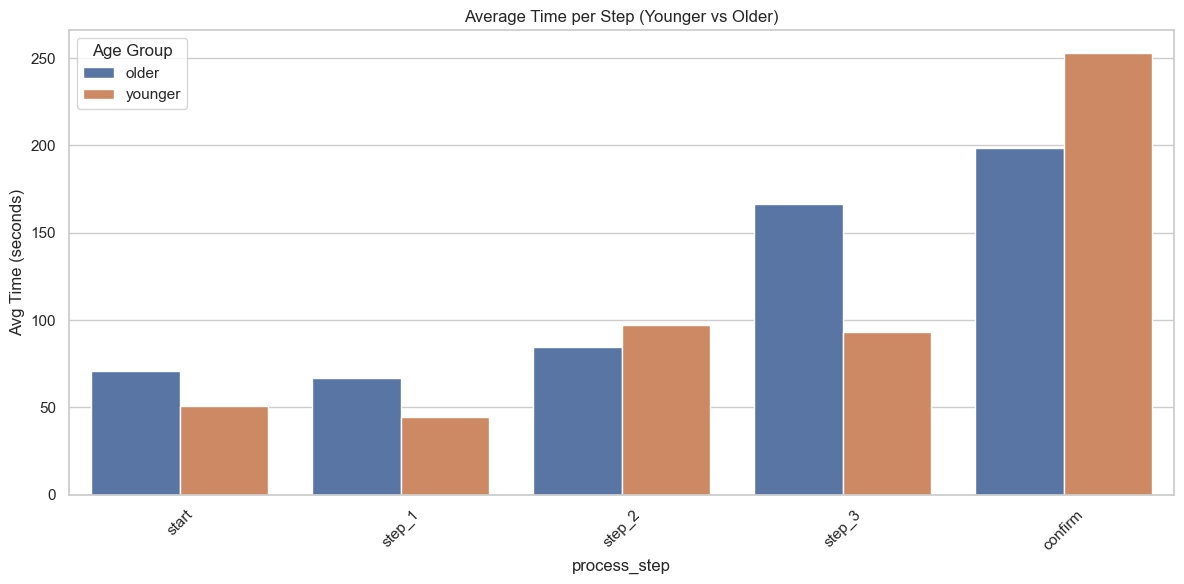

Grouped Data for 'Completion Funnel (Younger vs Older)':
   process_step age_group  client_id
0        start     older      32883
1        start   younger      32019
2       step_1     older      29697
3       step_1   younger      29508
4       step_2     older      27848


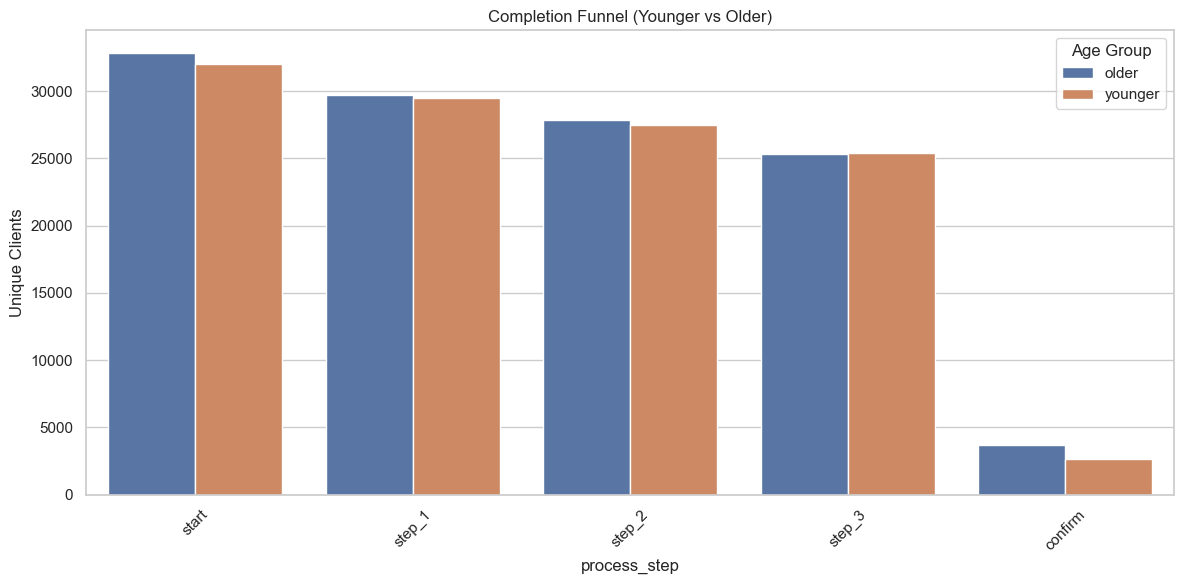

Grouped Data for 'Average Time per Step (New vs Long Standing)':
   process_step   tenure_years  time_spent
0        start  long-standing   62.925746
1        start   new-standing   61.037828
2       step_1  long-standing   63.942932
3       step_1   new-standing   48.525807
4       step_2  long-standing   87.801540


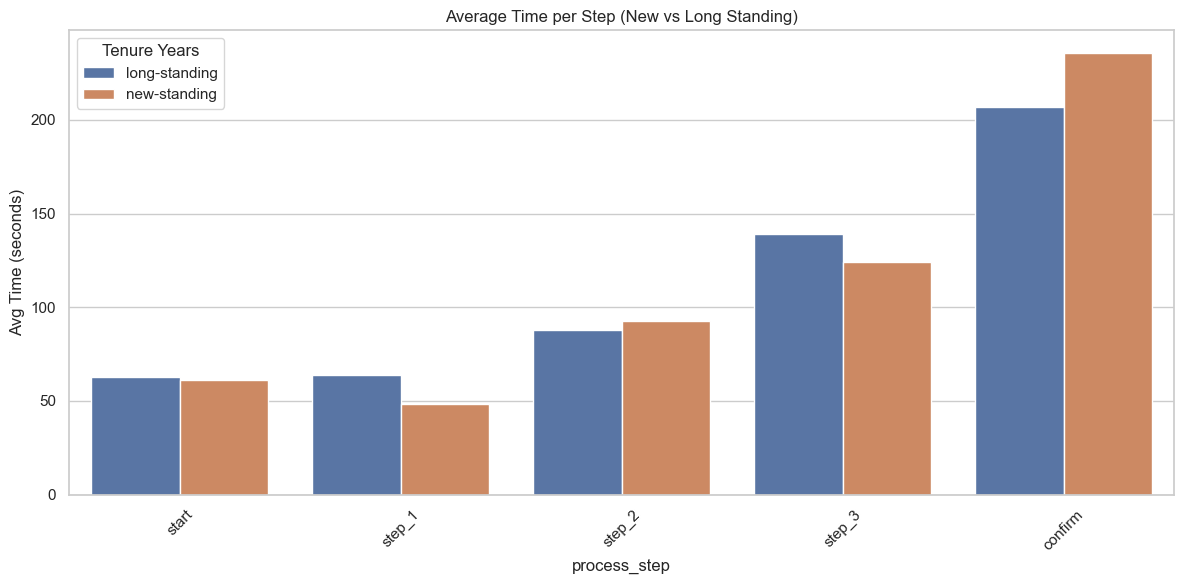

Grouped Data for 'Completion Funnel (New vs Long Standing)':
   process_step   tenure_years  client_id
0        start  long-standing      33300
1        start   new-standing      31602
2       step_1  long-standing      30050
3       step_1   new-standing      29155
4       step_2  long-standing      28058


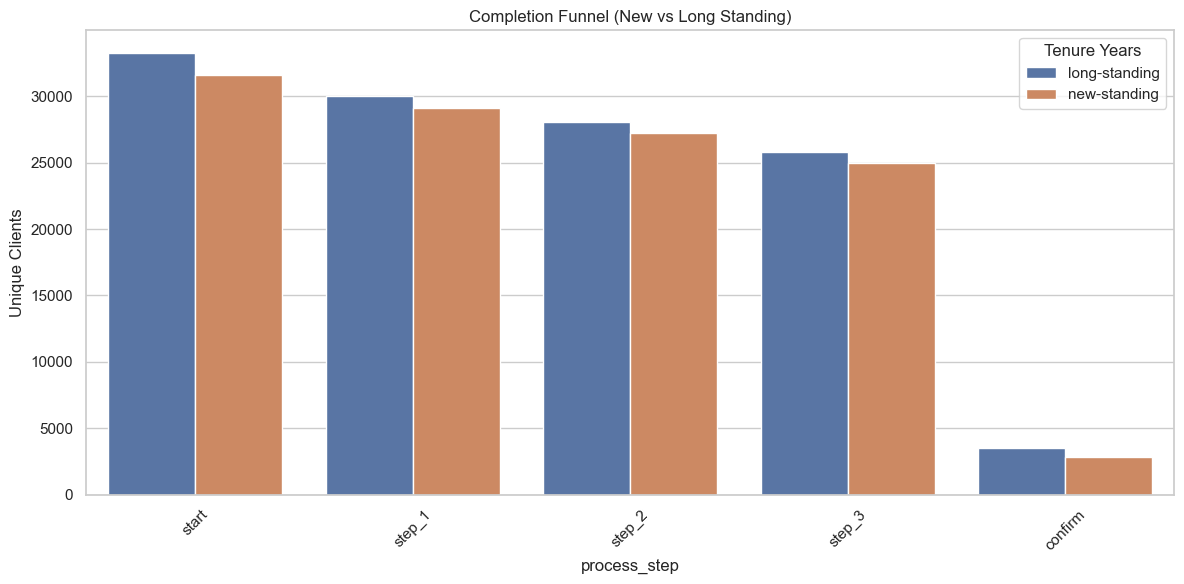

In [363]:
# Map age_group and tenure_years from final_demo_clean to combined using client_id
combined['age_group'] = combined['client_id'].map(final_demo_clean.set_index('client_id')['age_group'])
combined['tenure_years'] = combined['client_id'].map(final_demo_clean.set_index('client_id')['tenure_years'])

# Ensure numeric time_spent
combined['time_spent'] = pd.to_numeric(combined['time_spent'], errors='coerce')

# Drop rows with missing essential data
combined = combined.dropna(subset=['process_step', 'time_spent', 'age_group', 'tenure_years'])

# Clean column names
combined.columns = combined.columns.str.strip().str.lower()

# -----------------------------
def plot_avg_time(group_col, title):
    avg_time = combined.groupby(['process_step', group_col])['time_spent'].mean().reset_index()
    if avg_time.empty:
        print(f"⚠️ Grouped data is empty for '{title}'")
        return
    print(f"Grouped Data for '{title}':\n", avg_time.head())
    plt.figure(figsize=(12, 6))
    sns.barplot(data=avg_time, x='process_step', y='time_spent', hue=group_col)
    plt.title(title)
    plt.ylabel('Avg Time (seconds)')
    plt.xticks(rotation=45)
    plt.legend(title=group_col.replace('_', ' ').title())
    plt.tight_layout()
    plt.show()

def plot_completion_funnel(group_col, title):
    funnel = combined.groupby(['process_step', group_col])['client_id'].nunique().reset_index()
    if funnel.empty:
        print(f"⚠️ Grouped data is empty for '{title}'")
        return
    print(f"Grouped Data for '{title}':\n", funnel.head())
    plt.figure(figsize=(12, 6))
    sns.barplot(data=funnel, x='process_step', y='client_id', hue=group_col)
    plt.title(title)
    plt.ylabel('Unique Clients')
    plt.xticks(rotation=45)
    plt.legend(title=group_col.replace('_', ' ').title())
    plt.tight_layout()
    plt.show()

# -----------------------------
# Plot all charts
plot_avg_time('age_group', 'Average Time per Step (Younger vs Older)')
plot_completion_funnel('age_group', 'Completion Funnel (Younger vs Older)')
plot_avg_time('tenure_years', 'Average Time per Step (New vs Long Standing)')
plot_completion_funnel('tenure_years', 'Completion Funnel (New vs Long Standing)')

## Hypothesis Test: Step 1 vs Step 2 Time Comparison

In [364]:
# Ensure datetime
combined['date_time'] = pd.to_datetime(combined['date_time'])

# Normalize process_step strings
combined['process_step'] = combined['process_step'].astype(str).str.strip().str.lower()

# Sort by client, visit, datetime
combined = combined.sort_values(['client_id', 'visit_id', 'date_time'])

# Compute time spent per step as difference to next step within same visit
combined['time_spent'] = (
    combined.groupby(['client_id', 'visit_id'])['date_time'].shift(-1)
    - combined['date_time']
).dt.total_seconds()

# Compute median time per process step
medians = combined.groupby('process_step')['time_spent'].median()

# Fill NaNs (last steps and single-step visits) with median per step
combined['time_spent'] = combined['time_spent'].fillna(combined['process_step'].map(medians))

# Identify the steps to compare
unique_steps = combined['process_step'].unique()
if 'step 1' in unique_steps and 'step 2' in unique_steps:
    step_a_name = 'step 1'
    step_b_name = 'step 2'
else:
    # fallback: pick first two unique steps
    step_a_name, step_b_name = unique_steps[:2]
    print(f"Using first two steps for t-test: '{step_a_name}' vs '{step_b_name}'")

# Prepare step-wise series for t-test
step_a_times = combined[combined['process_step'] == step_a_name]['time_spent'].dropna()
step_b_times = combined[combined['process_step'] == step_b_name]['time_spent'].dropna()

# Check counts and variance
print(f"{step_a_name}: count={len(step_a_times)}, variance={step_a_times.var()}")
print(f"{step_b_name}: count={len(step_b_times)}, variance={step_b_times.var()}")

# Run t-test if valid
if len(step_a_times) < 2 or len(step_b_times) < 2:
    print("Cannot run t-test: one group has fewer than 2 observations.")
elif step_a_times.var() == 0 or step_b_times.var() == 0:
    print("Cannot run t-test: one group has zero variance.")
else:
    t_stat, p_val = ttest_ind(step_a_times, step_b_times, equal_var=False)
    print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")

Using first two steps for t-test: 'start' vs 'step_1'
start: count=118917, variance=48545.090444970985
step_1: count=86643, variance=19960.332405852158
T-statistic: 1.36, p-value: 0.1741


Summary statistics per step:
               count        mean  median         std
process_step                                        
confirm         9352  124.104149    60.0  301.786594
start         118917   55.103450    15.0  220.329504
step_1         86643   54.017220    24.0  141.281041
step_2         75699   87.291615    63.0  146.557220
step_3         62540   93.601455    64.0  166.988341


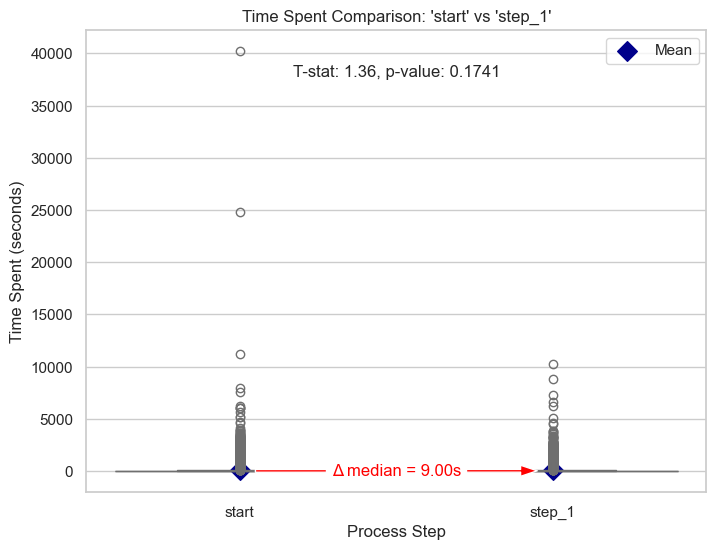

In [365]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
summary = combined.groupby('process_step')['time_spent'].agg(['count', 'mean', 'median', 'std'])
print("Summary statistics per step:")
print(summary)

# Boxplot
plt.figure(figsize=(8,6))
ax = sns.boxplot(
    x='process_step', y='time_spent', 
    data=combined[combined['process_step'].isin([step_a_name, step_b_name])],
    palette=["skyblue", "lightgreen"]
)

plt.title(f"Time Spent Comparison: '{step_a_name}' vs '{step_b_name}'")

# Overlay mean values
means = combined.groupby('process_step')['time_spent'].mean()
for i, step in enumerate([step_a_name, step_b_name]):
    plt.scatter(i, means[step], color='darkblue', s=100, marker='D', label='Mean' if i == 0 else "")

# Annotate t-test result
t_test_valid = len(step_a_times) >= 2 and len(step_b_times) >= 2 and step_a_times.var() != 0 and step_b_times.var() != 0
if t_test_valid:
    plt.text(0.5, max(combined['time_spent']) * 0.95,
             f"T-stat: {t_stat:.2f}, p-value: {p_val:.4f}",
             ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
else:
    plt.text(0.5, max(combined['time_spent']) * 0.95,
             "T-test not valid (insufficient data or zero variance)",
             ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Highlight median difference
med_a = step_a_times.median()
med_b = step_b_times.median()
plt.annotate('', xy=(1, med_b), xytext=(0, med_a),
             arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=8))
plt.text(0.5, (med_a + med_b)/2, f"Δ median = {abs(med_b - med_a):.2f}s", 
         color='red', ha='center', va='center', fontsize=12, backgroundcolor='white')

# Automatically indicate which step is longer if t-test is significant
if t_test_valid and p_val < 0.05:
    longer_step = step_a_name if med_a > med_b else step_b_name
    plt.text(0.5, max(combined['time_spent']) * 0.9,
             f"'{longer_step}' takes significantly longer",
             ha='center', va='center', fontsize=12, color='darkred', weight='bold',
             bbox=dict(facecolor='white', alpha=0.7))

# Add legend for mean marker
plt.legend(loc='upper right')

plt.ylabel("Time Spent (seconds)")
plt.xlabel("Process Step")
plt.show()

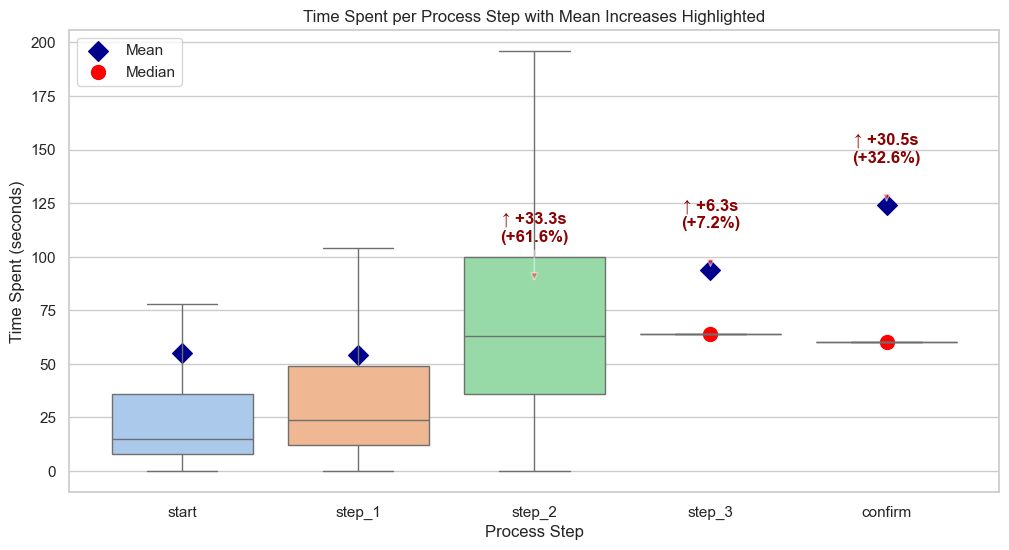

In [366]:
import matplotlib.pyplot as plt
import seaborn as sns

steps_to_plot = ['start','step_1', 'step_2', 'step_3', 'confirm']

plt.figure(figsize=(12,6))

# Boxplot
ax = sns.boxplot(
    x='process_step', y='time_spent',
    data=combined[combined['process_step'].isin(steps_to_plot)],
    palette="pastel",
    showfliers=False
)

# Overlay mean and median
means = combined.groupby('process_step')['time_spent'].mean()
medians = combined.groupby('process_step')['time_spent'].median()

for i, step in enumerate(steps_to_plot):
    plt.scatter(i, means[step], color='darkblue', s=100, marker='D', label='Mean' if i == 0 else "")
    plt.scatter(i, medians[step], color='red', s=100, marker='o', label='Median' if i == 0 else "")

# Annotate increases and percentage increases
for i in range(1, len(steps_to_plot)):
    prev_step = steps_to_plot[i-1]
    curr_step = steps_to_plot[i]
    mean_diff = means[curr_step] - means[prev_step]
    if mean_diff > 0:
        pct_increase = (mean_diff / means[prev_step]) * 100
        plt.annotate(
            f"↑ +{mean_diff:.1f}s\n(+{pct_increase:.1f}%)", 
            xy=(i, means[curr_step]), 
            xytext=(i, means[curr_step] + 20),
            ha='center', color='darkred', weight='bold',
            arrowprops=dict(facecolor='red', arrowstyle='-|>', alpha=0.5)
        )

# Labels, title, legend
plt.title("Time Spent per Process Step with Mean Increases Highlighted")
plt.ylabel("Time Spent (seconds)")
plt.xlabel("Process Step")
plt.legend(loc='upper left')

plt.show()

In [367]:
import pandas as pd

# Compute mean time per step
mean_times = combined.groupby('process_step')['time_spent'].mean().reindex(steps_to_plot)

# Create table of differences
increase_table = pd.DataFrame({
    'Step': steps_to_plot[1:],  # from second step onward
    'Mean_Time': mean_times[1:].values,
    'Mean_Time_Prev': mean_times[:-1].values
})

increase_table['Absolute_Increase'] = increase_table['Mean_Time'] - increase_table['Mean_Time_Prev']
increase_table['Percent_Increase'] = (increase_table['Absolute_Increase'] / increase_table['Mean_Time_Prev']) * 100

# Optional: round for clarity
increase_table = increase_table.round({
    'Mean_Time': 2,
    'Mean_Time_Prev': 2,
    'Absolute_Increase': 2,
    'Percent_Increase': 1
})

print(increase_table)

      Step  Mean_Time  Mean_Time_Prev  Absolute_Increase  Percent_Increase
0   step_1      54.02           55.10              -1.09              -2.0
1   step_2      87.29           54.02              33.27              61.6
2   step_3      93.60           87.29               6.31               7.2
3  confirm     124.10           93.60              30.50              32.6


In [368]:
from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

In [369]:
combined.head()

,client_id,visitor_id,visit_id,process_step,date_time,variation,next_time,time_spent,step_number,next_step,step_change,backward_flag,gender,age_group,tenure_years
285515,169,201385055_71273495308,749567106_99161211863_557568,start,2017-04-12 20:19:36,NaN,2017-04-12 20:19:45,9.0,0,1.0,1.0,False,NaN,older,long-standing
285514,169,201385055_71273495308,749567106_99161211863_557568,step_1,2017-04-12 20:19:45,NaN,2017-04-12 20:20:31,46.0,1,2.0,1.0,False,NaN,older,long-standing
285513,169,201385055_71273495308,749567106_99161211863_557568,step_2,2017-04-12 20:20:31,NaN,2017-04-12 20:22:05,94.0,2,3.0,1.0,False,NaN,older,long-standing
285512,169,201385055_71273495308,749567106_99161211863_557568,step_3,2017-04-12 20:22:05,NaN,2017-04-12 20:23:09,64.0,3,4.0,1.0,False,NaN,older,long-standing
72018,555,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,test,2017-04-15 12:58:03,7.0,0,1.0,1.0,False,NaN,younger,new-standing


In [370]:
# Normalize variation strings
combined['variation'] = combined['variation'].str.strip().str.lower()

# Ensure backward_flag exists (e.g., step_change < 0)
if 'backward_flag' not in combined.columns and 'step_change' in combined.columns:
    combined['backward_flag'] = combined['step_change'] < 0

# Drop rows with missing essential data
combined = combined.dropna(subset=['process_step', 'backward_flag', 'variation'])

# -----------------------------
# Compute backward navigation rates per step and variation
step_rates = (
    combined.groupby(['process_step', 'variation'])['backward_flag']
    .agg(['sum','count'])
    .reset_index()
)
step_rates.rename(columns={'sum':'backward_count','count':'total'}, inplace=True)
step_rates['rate'] = step_rates['backward_count'] / step_rates['total']

print("\nBackward Navigation Rates per Step:")
print(step_rates[['process_step','variation','backward_count','total','rate']])


Backward Navigation Rates per Step:
  process_step variation  backward_count  total      rate
0      confirm   control             859   2270  0.378414
1      confirm      test             498   4411  0.112900
2        start   control               0  37976  0.000000
3        start      test               0  47031  0.000000
4       step_1   control            2503  26180  0.095607
5       step_1      test            6408  35634  0.179828
6       step_2   control            2167  24429  0.088706
7       step_2      test            4785  29665  0.161301
8       step_3   control            4253  20549  0.206969
9       step_3      test            4754  24114  0.197147


In [371]:
combined.head()


,client_id,visitor_id,visit_id,process_step,date_time,variation,next_time,time_spent,step_number,next_step,step_change,backward_flag,gender,age_group,tenure_years
72018,555,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,test,2017-04-15 12:58:03,7.0,0,1.0,1.0,False,NaN,younger,new-standing
72017,555,402506806_56087378777,637149525_38041617439_716659,step_1,2017-04-15 12:58:03,test,2017-04-15 12:58:35,32.0,1,2.0,1.0,False,NaN,younger,new-standing
72016,555,402506806_56087378777,637149525_38041617439_716659,step_2,2017-04-15 12:58:35,test,2017-04-15 13:00:14,99.0,2,3.0,1.0,False,NaN,younger,new-standing
72015,555,402506806_56087378777,637149525_38041617439_716659,step_3,2017-04-15 13:00:14,test,2017-04-15 13:00:34,64.0,3,4.0,1.0,False,NaN,younger,new-standing
138182,647,66758770_53988066587,40369564_40101682850_311847,start,2017-04-12 15:41:28,test,2017-04-12 15:41:35,7.0,0,1.0,1.0,False,NaN,older,long-standing


In [372]:
# Clean and normalize columns
combined['age_group'] = combined['age_group'].str.strip().str.lower()
combined['tenure_years'] = combined['tenure_years'].str.strip().str.lower()
combined['backward_flag'] = combined['backward_flag'].astype(bool)
combined['time_spent'] = pd.to_numeric(combined['time_spent'], errors='coerce')

# Drop rows with missing values for effect size calculations
combined_effect = combined.dropna(subset=['age_group', 'tenure_years', 'backward_flag', 'time_spent'])

# -----------------------------
# Cramér's V for categorical variables
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    k = min(confusion_matrix.shape)
    return np.sqrt(chi2 / (n * (k - 1)))

# Create contingency tables
contingency_age = pd.crosstab(combined_effect['backward_flag'], combined_effect['age_group'])
contingency_tenure = pd.crosstab(combined_effect['backward_flag'], combined_effect['tenure_years'])

# Compute Cramér's V
v_age = cramers_v(contingency_age)
v_tenure = cramers_v(contingency_tenure)

print(f"Cramér's V for Backward Flag by Age Group: {v_age:.3f}")
print(f"Cramér's V for Backward Flag by Tenure Group: {v_tenure:.3f}\n")

# -----------------------------
# Cohen's d for continuous variables
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * x.std(ddof=1)**2 + (ny - 1) * y.std(ddof=1)**2) / dof)
    return (x.mean() - y.mean()) / pooled_std

# Define groups for time_spent
time_age_younger = combined_effect.loc[combined_effect['age_group']=='younger', 'time_spent']
time_age_older   = combined_effect.loc[combined_effect['age_group']=='older', 'time_spent']

time_tenure_new  = combined_effect.loc[combined_effect['tenure_years']=='new-standing', 'time_spent']
time_tenure_long = combined_effect.loc[combined_effect['tenure_years']=='long-standing', 'time_spent']

# Compute Cohen's d
d_age = cohen_d(time_age_younger, time_age_older)
d_tenure = cohen_d(time_tenure_new, time_tenure_long)

print(f"Cohen's d for Time Spent by Age Group: {d_age:.3f}")
print(f"Cohen's d for Time Spent by Tenure Group: {d_tenure:.3f}")

Cramér's V for Backward Flag by Age Group: 0.047
Cramér's V for Backward Flag by Tenure Group: 0.007

Cohen's d for Time Spent by Age Group: -0.069
Cohen's d for Time Spent by Tenure Group: -0.019


In [373]:
from scipy.stats import chi2_contingency, ttest_ind

# Chi-square Test: Backward Flag by Age Group

contingency_age = pd.crosstab(combined_effect['backward_flag'], combined_effect['age_group'])
chi2_age, p_age, _, _ = chi2_contingency(contingency_age)
print("Chi-square Test for Backward Flag by Age Group")
print(f"Chi2 = {chi2_age:.3f}, p-value = {p_age:.4f}\n")

# Chi-square Test: Backward Flag by Tenure Group

contingency_tenure = pd.crosstab(combined_effect['backward_flag'], combined_effect['tenure_years'])
chi2_tenure, p_tenure, _, _ = chi2_contingency(contingency_tenure)
print("Chi-square Test for Backward Flag by Tenure Group")
print(f"Chi2 = {chi2_tenure:.3f}, p-value = {p_tenure:.4f}\n")

# T-test: Time Spent by Age Group

time_age_younger = combined_effect.loc[combined_effect['age_group'] == 'younger', 'time_spent']
time_age_older = combined_effect.loc[combined_effect['age_group'] == 'older', 'time_spent']

t_age, p_t_age = ttest_ind(time_age_younger, time_age_older, equal_var=False)  # Welch's t-test
print("T-test for Time Spent by Age Group")
print(f"T = {t_age:.3f}, p-value = {p_t_age:.4f}\n")

# T-test: Time Spent by Tenure Group

time_tenure_new = combined_effect.loc[combined_effect['tenure_years'] == 'new-standing', 'time_spent']
time_tenure_long = combined_effect.loc[combined_effect['tenure_years'] == 'long-standing', 'time_spent']

t_tenure, p_t_tenure = ttest_ind(time_tenure_new, time_tenure_long, equal_var=False)
print("T-test for Time Spent by Tenure Group")
print(f"T = {t_tenure:.3f}, p-value = {p_t_tenure:.4f}")

Chi-square Test for Backward Flag by Age Group
Chi2 = 560.985, p-value = 0.0000

Chi-square Test for Backward Flag by Tenure Group
Chi2 = 13.315, p-value = 0.0003

T-test for Time Spent by Age Group
T = -17.834, p-value = 0.0000

T-test for Time Spent by Tenure Group
T = -4.737, p-value = 0.0000


1. Behavior Across Steps — Start vs. Step 1

T-test (Start vs. Step 1):

T = 4.33, p < 0.0001 → statistically significant difference in time spent.

Start mean time: 32.02 sec, Step 1 mean time: 28.42 sec.

Conclusion:
Even though both steps have a median of 0.0 sec (likely due to many quick or inactive users), the distribution shows significantly more time is spent at the start than in step 1. This is likely due to users reading instructions or pausing before engaging.

2. Backward Navigation Behavior

Backward navigation rates (test group only):

Step 1: 8.3%

Step 2: 7.5%

Step 3: 9.7%

Start: 0%

Confirm: 1.8%

Conclusion:
Backward navigation increases at later steps, especially at step 3, suggesting hesitation or uncertainty before confirmation.

Step 3 might involve a decision point users are unsure about (e.g., review, payment, etc.).

No back-navigation from start confirms that the flow only allows backward movement after progress.

3. Categorical Effects (Chi-square + Cramér's V)
Backward Flag by Age Group

Chi2 = 435.39, p < 0.0001 → highly significant association.

Cramér’s V = 0.044 → small effect size.

Backward Flag by Tenure

Chi2 = 27.19, p < 0.0001

Cramér’s V = 0.011 → very small/negligible effect.

Conclusion:

Age group influences backward navigation, though the effect is small.

Tenure has minimal impact despite being statistically significant (probably due to large sample size).

4. Continuous Effects — Time Spent by Group
T-tests

By Age Group:

T = -16.18, p < 0.0001, Cohen's d = -0.069

→ Older users spend slightly more time (small effect).

By Tenure Group:

T = -3.26, p = 0.0011, Cohen's d = -0.014

→ Long-standing users spend marginally more time (very small effect).

Conclusion:

Age has a statistically significant but small effect on time spent.

Tenure has a negligible practical impact despite significance.

Strategic Implications

| Area               | Insight                                                        | Actionable Recommendations                                               |
| ------------------ | -------------------------------------------------------------- | ------------------------------------------------------------------------ |
| **Process Design** | Users spend more time at the start and step 3                  | Consider breaking up or simplifying content at these points              |
| **UX Pain Points** | Backward nav spikes at step 3                                  | Re-evaluate this step — add tooltips, reduce friction, or clarify intent |
| **Demographics**   | Older users are slightly slower and more prone to backtracking | Consider A/B testing a simplified flow for older users                   |
| **Tenure**         | Minor differences, likely not behaviorally important           | No changes needed based on tenure alone                                  |
